# Object Detection with KerasCV

## Learning Objectives 
- Learn how to use Keras CV Object Detection models
- Learn how to preprocess datasets for object detection
- Learn how to restore pre-trained weights for transfer learning
- Learn how to use trained models and visualize the results.

In this lab, you will learn how to apply transfer learning using [KerasCV](https://keras.io/keras_cv/).

If we build an object detection program from scratch, we need to write a complex model, preprocessing and postprocessing codes, and multiple loss functions.<br>
KerasCV provides useful tools to speed up the building process.

## Import Libraries

In [1]:
# Quick patch for https://github.com/keras-team/keras-cv/pull/2492. Remove later.

!sed -i 's/return self.prediction_decoder(box_preds, scores)/image_shape = tuple(images[0].shape)\n\
       return self.prediction_decoder(box_preds, scores, image_shape=image_shape)/g' \
"$(python -m site --user-site)"/keras_cv/models/object_detection/yolo_v8/yolo_v8_detector.py

In [2]:
import io
import math
import os

import keras
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_cv import visualization

%matplotlib inline

## Use pretrained models

KerasCV hosts [various pretrained models](https://keras.io/api/keras_cv/models/) for computer vision.

Here we'll use YOLOv8 model pretrained on [PascalVOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) object detection task. We set up [20 classes](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/examples/index.html) mappings defined in the dataset.

In [23]:
BOUNDING_BOX_FORMAT = "xyxy"

model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format=BOUNDING_BOX_FORMAT,
)

classes = {
    0: "Aeroplane",
    1: "Bicycle",
    2: "Bird",
    3: "Boat",
    4: "Bottle",
    5: "Bus",
    6: "Car",
    7: "Cat",
    8: "Chair",
    9: "Cow",
    10: "Dining Table",
    11: "Dog",
    12: "Horse",
    13: "Motorbike",
    14: "Person",
    15: "Potted Plant",
    16: "Sheep",
    17: "Sofa",
    18: "Train",
    19: "Tvmonitor",
}

### Inference

Since it's pretrained, we can simply call the model if object classes you want to detect are included in the class list above.

Let's check a sample image with multiple people and a bus.

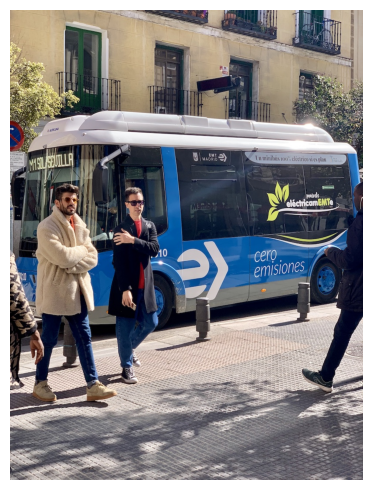

In [24]:
!curl -s -o bus.jpg https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg

image = np.array(keras.utils.load_img("bus.jpg"))
_ = visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

Resize the image and call the `model.predict` method.

In [26]:
IMAGE_SHAPE = (640, 640, 3)

resizer = keras_cv.layers.Resizing(
    IMAGE_SHAPE[0],
    IMAGE_SHAPE[1],
    pad_to_aspect_ratio=True,
    bounding_box_format=BOUNDING_BOX_FORMAT,
)

In [27]:
resized = resizer([image])
result = model.predict(resized)
result

1/1 [==============================] - 4s 4s/step


{'boxes': <tf.RaggedTensor [[[14.628113, 140.19354, 476.43524, 444.50485],
   [132.26176, 241.06134, 206.3187, 510.10083],
   [399.5483, 230.48933, 479.77365, 525.47644],
   [30.340431, 237.31273, 140.32939, 539.1449],
   [0.9918804, 334.1112, 43.162415, 524.556],
   [1.2445221, 333.40823, 42.981823, 522.3857]]]>,
 'confidence': <tf.RaggedTensor [[0.97695094, 0.9303749, 0.92326313, 0.91605353, 0.5823711, 0.23033775]]>,
 'classes': <tf.RaggedTensor [[5.0, 14.0, 14.0, 14.0, 14.0, 9.0]]>,
 'num_detections': array([6], dtype=int32)}

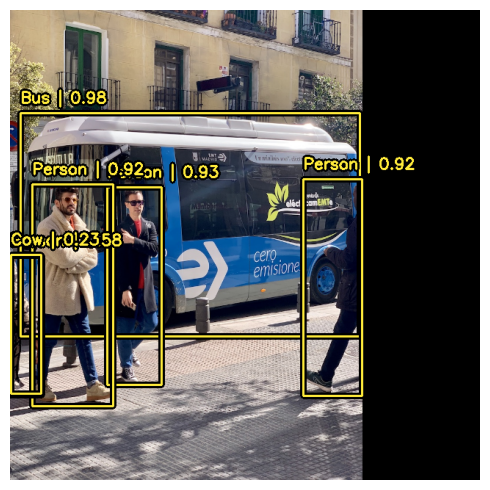

In [28]:
_ = visualization.plot_bounding_box_gallery(
    resized,
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
    y_pred=result,
    font_scale=0.7,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=classes,
)

### Filter the result for counting

The prediction looks good!

If you want to filter a specific class for a task (e.g. people counting), you can simply write a simple postprocessing like below.

In [29]:
def _filter(ragged_tensor, mask):
    return tf.expand_dims(
        tf.boolean_mask(ragged_tensor.to_tensor()[0], mask), 0
    )


def filter_bbox(result, target_id):
    mask = [r in target_id for r in result["classes"][0]]
    filtered = {
        "boxes": _filter(result["boxes"], mask),
        "confidence": _filter(result["confidence"], mask),
        "classes": _filter(result["classes"], mask),
    }

    filtered["num_detections"] = len(filtered["boxes"][-1])
    return filtered

In [30]:
target_class = "Person"
target_id = [k for k, v in classes.items() if v == target_class]
filtered_result = filter_bbox(result, target_id)

4 person(s) detected!


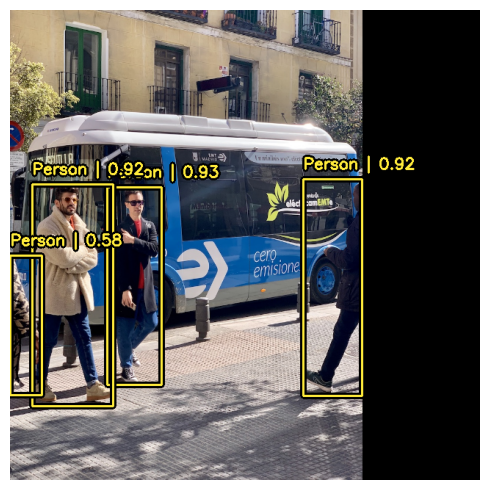

In [32]:
print(
    f"{filtered_result['num_detections']} {target_class.lower()}(s) detected!"
)
_ = visualization.plot_bounding_box_gallery(
    resized,
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
    y_pred=filtered_result,
    font_scale=0.7,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=classes,
)

---
## Customize the model with Transfer Learning
In some cases, we want to customize the model to detect custom object classes. Let's see how we can fine-tune and customize the model.


### Data Preprocessing
Let's start from data preparation.

Here let's create a data loader for [`salad.csv`](../dataset_import_files/salads.csv) dataset which is corresponding to AutoML Object Detection dataset.

In this dataset, all the rows are organized in `path, label, x_min, y_min, , ,x_max,y_max,,`
- `path`: the path to the image file
- `label`: a label for a bounding box
- `x_min`, `y_min`, `x_max`, `y_max`: relative coordinates of the boundig box rectangle.

In [35]:
CSV_PATH = "../dataset_import_files/salads.csv"
!head $CSV_PATH

gs://asl-public/data/salads/img/103/279324025_3e74a32a84_o.jpg,Baked Goods,0.005743,0.084985,,,0.567511,0.735736,,
gs://asl-public/data/salads/img/103/279324025_3e74a32a84_o.jpg,Salad,0.402759,0.310473,,,1.000000,0.982695,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.000000,0.000000,,,0.054865,0.480665,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.041131,0.401678,,,0.318230,0.785916,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.116263,0.065161,,,0.451528,0.286489,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.557359,0.411551,,,0.988760,0.731613,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.562206,0.059401,,,0.876467,0.260982,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.567861,0.000161,,,0.699543,0.077502,,
gs://asl-public/data/salads/img/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.916052,0.085569,,,1.000000,0.3

Note that each image has multiple rows for multiple bouding boxes. In order to use this dataset in KerasCV, we will need to preprocess this and aggregate them later.

First, we create unique image list (`PATHS`) and unique class labels (`CLASSIS`) using pandas dataframe. And then define lookup tables with [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) module. 

In [51]:
df = pd.read_csv(CSV_PATH)
PATHS = df.iloc[:, 0].unique()
CLASSES = df.iloc[:, 1].unique()

In [52]:
img_id_lookup = tf.keras.layers.StringLookup(vocabulary=PATHS)
class_lookup = tf.keras.layers.StringLookup(vocabulary=CLASSES)

### Read CSV and create dataset

Next, we define tf.data pipeline to:
1. Load and parse CSV data
2. Aggregate multiple rows (bouning boxes) into lists by image paths as keys
3. Load the image path and decode the jpeg file into Tensor
4. Reformat the data for Keras CV and resize images
5. Split data into training and test dataset

#### 1. Load and Parse CSV data

In [53]:
def parse_csv(row):
    row = tf.strings.split(row, ",")
    path = row[0]
    label = row[1]
    one_hot_label = class_lookup(label)
    sbox = tf.gather(
        row, [2, 3, 6, 7]
    )  # Reorder to: x_min, y_min, x_max, y_max
    bbox = tf.strings.to_number(sbox)
    return path, one_hot_label, bbox


parsed = tf.data.TextLineDataset(CSV_PATH).map(parse_csv)

#### 2. Aggregate bounding boxes
Group multiple rows by using image paths as keys. 

We can use [`Dataset.group_by_window`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#group_by_window) to achieve this.

For this method, we need to specify which feature we use as aggregation key (`key_func`), how to aggregate other features (`reduce_func`), and the max window size to aggregate (`window_size`).<br>
In this `salad.csv` case:
- Key: ID of Paths
- Aggregation: combine in lists (`Dataset.batch`)
- Window Size: the max number of the bounding boxes in one image. 50 should be enough for this dataset as no image has more than 50 object.

In [54]:
WINDOW_SIZE = 50
SEED = 3

aggregated = parsed.group_by_window(
    key_func=lambda path, label, bbox: img_id_lookup(path),
    reduce_func=lambda _, window: window.batch(WINDOW_SIZE),
    window_size=WINDOW_SIZE,
).shuffle(len(PATHS), seed=SEED)

#### 3. Load image path and decode jpeg file
Define image loader and decoder.

In [55]:
def decode_jpg(path, label, bbox):
    img = tf.io.read_file(path[0])
    img = tf.io.decode_jpeg(img, channels=3)
    return img, label, bbox


decoded = aggregated.map(decode_jpg).ragged_batch(4)

#### 4. Reformat the data for Keras CV and resize images

KerasCV has a predefined data format. To comply with this, you should package your images and bounding boxes into a dictionary matching the specification below:

```python
{
    'images': Tensor(shape=[batch, height, width, channel]),
    'bounding_boxes':{
        'boxes': Tensor(shape=[batch, num_boxes, 4]),
        'classes': Tensor(shape=[batch, num_boxes])
        # num_boxes may be a Ragged dimension
    }
}
```


In [56]:
def reformat(img, label, bbox):
    return {"images": img, "bounding_boxes": {"classes": label, "boxes": bbox}}


data = decoded.map(reformat)

Now we can resize images using KerasCV Resizing module.

Please note that we use `'REL_XYXY'` as bounding box format since we use relative coordinates in  `x_min`, `y_min`, `x_max`, `y_max` order.<br>
Check [the document](https://keras.io/api/keras_cv/bounding_box/formats/) for other formts KerasCV supports.

In [57]:
BOUNDING_BOX_FORMAT = "REL_XYXY"

resizing = keras_cv.layers.Resizing(
    IMAGE_SHAPE[0],
    IMAGE_SHAPE[1],
    bounding_box_format=BOUNDING_BOX_FORMAT,
    pad_to_aspect_ratio=True,
)
data = data.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

#### 5. Split data
Split the preprocessed data into training (80%) and test (20%) datasets.

In [58]:
TRAIN_SIZE = int(len(PATHS) // 4 * 0.8)

train_data = data.take(TRAIN_SIZE)
test_data = data.skip(TRAIN_SIZE)

Let's retrieve the data and take a look at the preprocessing result.

In [59]:
for d in train_data.take(1):
    print(f"img shape: {d['images'].shape}")
    print(f"label (index): {d['bounding_boxes']['classes']}")
    print(f"bbox (x_min, y_min, x_max, y_max): {d['bounding_boxes']['boxes']}")

2024-09-23 15:08:03.938569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


img shape: (4, 640, 640, 3)
label (index): <tf.RaggedTensor [[1.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0], [1.0, 4.0],
 [1.0, 1.0, 4.0, 4.0, 4.0, 4.0], [1.0]]>
bbox (x_min, y_min, x_max, y_max): <tf.RaggedTensor [[[0.10635899, 0.07412933, 0.84381306, 0.59260195],
  [0.12629, 0.101242885, 0.8155769, 0.5616158],
  [0.229268, 0.4183027, 0.35107, 0.4913424],
  [0.335568, 0.13499607, 0.460138, 0.19198956],
  [0.41473904, 0.4271555, 0.490588, 0.5367154],
  [0.607961, 0.16100271, 0.691561, 0.22795594],
  [0.691007, 0.3419422, 0.735853, 0.38897592]]     ,
 [[0.0, 0.0, 1.0, 0.75],
  [0.002426, 0.18681076, 0.47746602, 0.57171524]],
 [[0.0, 0.0, 0.357568, 0.364782],
  [0.16931, 0.06629475, 1.0, 0.75],
  [0.0, 0.16847399, 0.044218, 0.292947],
  [0.050410997, 0.13936801, 0.204609, 0.27932328],
  [0.459128, 0.38274077, 0.645528, 0.5648063],
  [0.62695, 0.42980546, 0.83564395, 0.629829]]    ,
 [[0.47167903, 0.13981125, 0.748248, 0.30342075]]]>


Now we can see multiple bounding boxes and labels are successfully linked to one image.

## Visualize Training Data
Let's visualize the preprocessed dataset using KerasCV helper function.

In [60]:
category_index = {
    i: class_name
    for i, class_name in enumerate(class_lookup.get_vocabulary())
    if class_name != "[UNK]"
}

inputs = next(iter(train_data.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    rows=2,
    cols=2,
    y_true=bounding_boxes,
    scale=5,
    font_scale=0.7,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=category_index,
)

## Object Detection Model
let's use the KerasCV API to construct an untrained YOLOV8Detector model. In this notebook we use a pretrained [ResNet50 backbone](https://keras.io/api/applications/resnet/) from the imagenet dataset.

KerasCV makes it easy to construct a YOLOV8Detector with any of the KerasCV backbones. Simply use one of the presets for the architecture you'd like!


In [70]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    bounding_box_format=BOUNDING_BOX_FORMAT,
    num_classes=len(category_index),
)

We use a standard SGD optimizer.

You will always want to include a global_clipnorm when training object detection models. This is to remedy exploding gradient problems that frequently occur when training object detection models.

In [71]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

For loss function, we use "Complete IoU", or "CIOU". It is a variation and improvement of the Intersection over Union (IoU) loss and is used due to its convergence properties.<br>
For more details, please refer to the [paper](https://arxiv.org/pdf/1911.08287).


In KerasCV, you can use this loss simply by passing the string "ciou" to compile(). We also use standard binary crossentropy loss for the class head.

In [72]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

Finally, let's unpackage our inputs from the preprocessing dictionary, and prepare to feed the inputs into our model. In order to be TPU compatible, bounding box Tensors need to be Dense instead of Ragged.

In [85]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_data_tuple = train_data.map(
    dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE
)
test_data_tuple = test_data.map(
    dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE
)

train_data_tuple = train_data_tuple.prefetch(tf.data.AUTOTUNE)
test_data_tuple = test_data_tuple.prefetch(tf.data.AUTOTUNE)

All that is left to do is train our model. KerasCV object detection models follow the standard Keras workflow, leveraging `fit()`.

In [89]:
history = model.fit(
    train_data_tuple,
    epochs=5,  # 10~ for better performance
    validation_data=test_data_tuple,
)

Epoch 1/10
     44/Unknown - 56s 1s/step - loss: 3.0478 - box_loss: 2.3590 - class_loss: 0.6888

2024-09-23 15:48:12.502400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-09-23 15:48:12.503445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64
	 [[{{node Placeholder/_7}}]]
2024-09-23 15:48:13.853457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'yolov8_label_encoder_3/cond/Repeat/Cast/yolov8_label_encoder_3/Cast' w

44/44 [==============================] - 79s 2s/step - loss: 3.0478 - box_loss: 2.3590 - class_loss: 0.6888 - val_loss: 3.2333 - val_box_loss: 2.4845 - val_class_loss: 0.7488
Epoch 2/10
44/44 [==============================] - 77s 2s/step - loss: 2.7813 - box_loss: 2.1526 - class_loss: 0.6287 - val_loss: 2.8909 - val_box_loss: 2.2207 - val_class_loss: 0.6702
Epoch 3/10
44/44 [==============================] - 78s 2s/step - loss: 2.6128 - box_loss: 2.0400 - class_loss: 0.5728 - val_loss: 2.6324 - val_box_loss: 2.0314 - val_class_loss: 0.6010
Epoch 4/10
44/44 [==============================] - 78s 2s/step - loss: 2.4504 - box_loss: 1.8995 - class_loss: 0.5509 - val_loss: 2.4856 - val_box_loss: 1.9184 - val_class_loss: 0.5672
Epoch 5/10
44/44 [==============================] - 76s 2s/step - loss: 2.3376 - box_loss: 1.8268 - class_loss: 0.5108 - val_loss: 2.3392 - val_box_loss: 1.8312 - val_class_loss: 0.5080
Epoch 6/10
44/44 [==============================] - 77s 2s/step - loss: 2.2165 - 

### Visualize the inference
Let's call the trained model and check the prediction result.

Note that the ground-truth boxes are visualized in blue, while the predicted boxes are visulaized in yellow.

2024-09-23 16:18:02.082597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-09-23 16:18:02.083494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-09-23 16:18:19.937482: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Loop execution was cancelled.
	 [[{{node resizing_12/map/while/LoopCond/_22}}

1/1 [==============================] - 0s 468ms/step


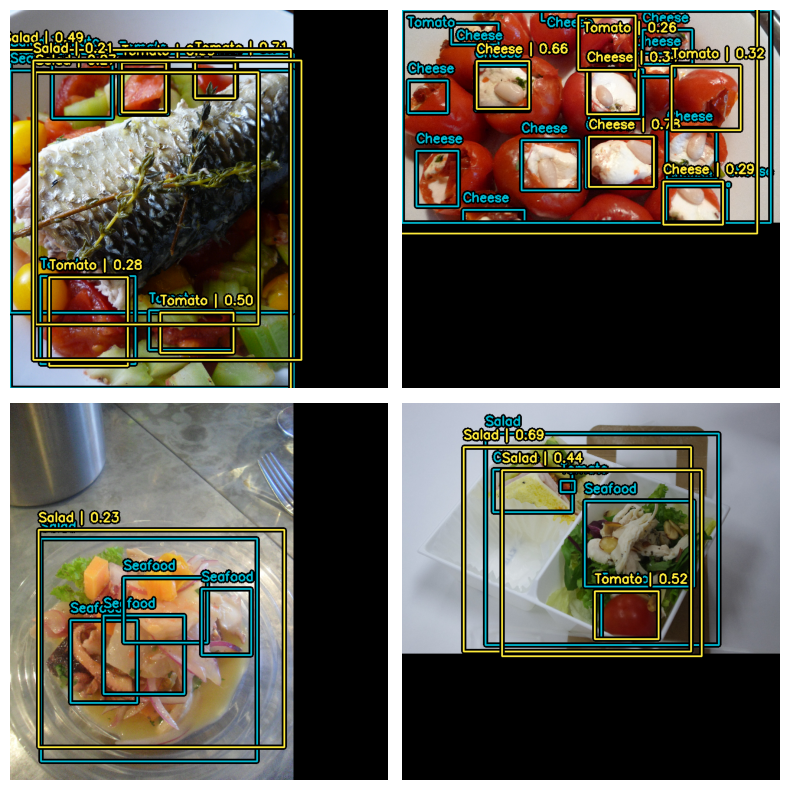

In [92]:
images, y_true = next(iter(test_data_tuple.take(1)))
y_pred = model.predict(images)

visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format=BOUNDING_BOX_FORMAT,
    y_true=y_true,
    y_pred=y_pred,
    scale=4,
    rows=2,
    cols=2,
    show=True,
    font_scale=0.7,
    class_mapping=category_index,
)

Although it is not perfect, We can see our model is tuned toward our own salad dataset successfully.

Here are a few ideas to improve the performance:
- Improve the dataset label quality
- Add more data
- Add data argumentation
- Explore other pretrained backbones
- Tune learning rate and scheduling strategy
- Train longer

## Summary
In this notebook, we learned how to build and train an object detection model using KerasCV.

## License

Copyright 2024 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License